In [1]:
import bet.postProcess.compareP as cp
import bet.sampling.basicSampling as bsam
import bet.sample as sample
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as wd
import bet.calculateP.calculateP as calcP
import scipy.spatial.distance as ds


In [2]:
def set_center(num_samples=100,
                   dim=2,
                   delta=0.1, reg=False):
    r"""
    Make unit square domain, create a hyperrectangle with sidelengths
    delta centered around `np.array([[0.5]]*dim)
    """
    s_set = sample.sample_set(dim)
    s_set.set_domain(np.array([[0, 1]]*dim))
    if reg:
        s = bsam.regular_sample_set(s_set, num_samples)
    else:
        s = bsam.random_sample_set('r', s_set, num_samples)
    dd = delta/2.0
    if dim > 1:
        probs = 1*(np.sum(np.logical_and(s._values <= (0.5+dd),
                                     s._values >= (0.5-dd)), axis=1) >= dim-1)
    else:
        probs = 1*(np.logical_and(s._values <= (0.5+dd),
                                     s._values >= (0.5-dd)))
    s.set_probabilities(probs/np.sum(probs))  # uniform probabilities
    s.estimate_volume_mc()
    s.global_to_local()
    return s

def set_zero(num_samples=100,
                   dim=2,
                   delta=0.1, reg=False):
    r"""
    Make unit square domain, create a hyperrectangle with sidelengths
    delta centered around `np.array([[0.5]]*dim)
    """
    s_set = sample.sample_set(dim)
    s_set.set_domain(np.array([[0, 1]]*dim))
    if reg:
        s = bsam.regular_sample_set(s_set, num_samples)
    else:
        s = bsam.random_sample_set('r', s_set, num_samples)    
    dd = delta
    if dim == 1:
        probs = 1*(s._values <= dd)
    else:
        probs = 1*(np.sum(s._values <= dd, axis=1) >= dim-1)
    s.set_probabilities(probs/np.sum(probs))  # uniform probabilities
    s.estimate_volume_mc()
    s.global_to_local()
    return s

def set_one(num_samples=100,
                   dim=2,
                   delta=0.1, reg=False):
    r"""
    Make unit square domain, create a hyperrectangle with sidelengths
    delta centered around `np.array([[0.5]]*dim)
    """
    s_set = sample.sample_set(dim)
    s_set.set_domain(np.array([[0, 1]]*dim))
    if reg:
        s = bsam.regular_sample_set(s_set, num_samples)
    else:
        s = bsam.random_sample_set('r', s_set, num_samples)
    
    dd = delta
    if dim == 1:
        probs = 1*(s._values >= (1-dd))
    else:
        probs = 1*(np.sum(s._values >= (1-dd), axis=1) >= dim-1)
    s.set_probabilities(probs/np.sum(probs))  # uniform probabilities
    s.estimate_volume_mc()
    s.global_to_local()
    return s

def check_densities(s_set, dim=2, delta=0.1, tol=1e-4):
    # density values should be reciprocal of delta^dim
    s = s_set
    dd = delta/2.0
    if dim > 1:
        marks = 1*(np.sum(np.logical_and(s._values <= (0.5+dd),
                                     s._values >= (0.5-dd)), axis=1) >= dim-1)
    else:
        marks = 1*(np.logical_and(s._values <= (0.5+dd),
                                     s._values >= (0.5-dd)))
        
    true_den_val = 1.0/(delta**dim)  
    err = np.mean(np.abs(s_set._den - true_den_val*(marks))) 
    if err < tol:
        return 1
    else:
        return err
    
def answer_sq_hell(dim,d1=0.1,d2=0.2):
    f1 = d1**(-dim)
    f2 = d2**(-dim)
    s1, s2 = np.sqrt(f1), np.sqrt(f2)
    
    single = s2*(d2-d1)
    overlap = d1*(s1-s2)
    return (single + overlap)/2

def answer_tv(dim,d1=0.1,d2=0.2):
    f1 = d1**(-dim)
    f2 = d2**(-dim)
    
    single = f2*(d2-d1)
    overlap = d1*(f1-f2)
    return np.array(single + overlap)/2

In [59]:
dim=1
n=1000
n1=1000
n2=1000
delta = 0.3
# s = set_unit_probs(n1, dim, delta)
# r = set_unit_probs(n2, dim, delta)
s = set_zero(n1, dim, delta)
r = set_one(n2, dim, delta)
i = sample.sample_set(dim)
i.set_domain(np.array([[0, 1]]*dim))
I = bsam.random_sample_set('r', i, n)
i = bsam.regular_sample_set(i, n//10)
m = cp.metrization(I,s,r)
m.estimate_density()
check_densities(s,dim,delta,0.01)

1.4285197368421054

In [60]:
s._den.shape, i._values.shape

((1000,), (100, 1))

## Use `calcP.prob_from_sample_set` to compare

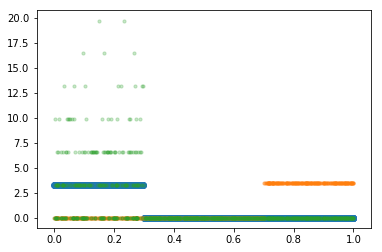

In [61]:
plt.scatter(I._values, s._den, alpha=1)
plt.scatter(I._values, r._den, alpha=0.25,s=10)

calcP.prob_from_sample_set(s,I)
I._volumes = s._volumes[m.get_io_ptr_left()]
I._probabilities /= I._volumes
plt.scatter(I._values, I._probabilities, alpha=0.25,s=10)
# plt.ylim(0,2)

(0, 0.01)

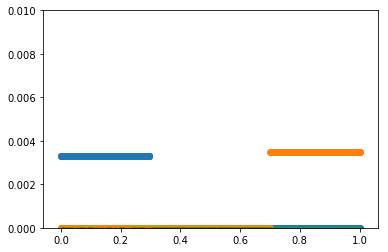

In [70]:
plt.scatter(I._values, s._prob)
plt.scatter(I._values, r._prob)
plt.scatter(I._values, I._probabilities, alpha=0.5,s=2)
plt.ylim(0,0.01)

In [ ]:
I.estimate_volume_mc()
cp.set_density(I)
plt.scatter(I._values, I._den)

Something strange is happening...

In [6]:
np.sum(I._probabilities)

1000.0

# Testing Meshes and Sample Sizes

In [53]:
def preview1d_reg(n=100, n_mesh=100, n_ref=1000, delta1=0.1, delta2=0.2,
                  c1='r',c2='r',reg_mesh=False, reg_ref=False, dim=1):
    if c1 =='r':
        s = set_one(n_ref, dim, delta1, reg_ref)
    elif c1=='l':
        s = set_zero(n_ref, dim, delta1, reg_ref)
    else:
        s = set_center(n_ref, dim, delta1, reg_ref)
        
    if c2 =='r':
        r = set_one(n_mesh, dim, delta2, reg_mesh)
    elif c2 =='l':
        r = set_zero(n_mesh, dim, delta2, reg_mesh)
    else:
        r = set_center(n_mesh, dim, delta2, reg_mesh)
    np.random.seed(10)
    i = sample.sample_set(dim)
    i.set_domain(np.array([[0, 1]]*dim))
    I = bsam.random_sample_set('r', i, n)
    s = cp.set_density(s)
    r = cp.set_density(r)
    mm = cp.metrization(I,s,r)
    mm.estimate_density()
    
#     print(check_densities(s,dim,delta1,0.05))
#     print(check_densities(r,dim,delta2,0.05))
    
    if dim == 1:
        plt.scatter(I._values, s._den)
        plt.scatter(I._values, r._den)
        plt.ylim(0,15)
        plt.hlines(5,0,1)
        plt.hlines(10,0,1)
    print(mm.distance(),mm.distance('sqhell'))
#     print(answer_tv(dim,delta1,delta2),
#           answer_sq_hell(dim,delta1,delta2))
#     print(0.5*np.sum(np.abs(mm._den_left - mm._den_right))/I.check_num())
wd.interact(preview1d_reg, 
            n=wd.IntSlider(500,100,10000,step=100, continuous_update=False),
            n_ref=wd.IntSlider(500,100,10000,step=100, continuous_update=False),
            n_mesh=wd.IntSlider(500,100,10000,step=100, continuous_update=False),
            delta1=wd.FloatSlider(0.1,min=0.1,max=.75,step=0.05),
            delta2=wd.FloatSlider(0.1,min=0.1,max=.75,step=0.05),
            c1=wd.Dropdown(options=['c','r','l']), c2=wd.Dropdown(options=['c','r','l']),
            reg_ref=wd.Checkbox(description="Regular Ref"),
            reg_mesh=wd.Checkbox(description="Regular Mesh"),
            dim=wd.IntSlider(1,1,5)
           )

interactive(children=(IntSlider(value=500, continuous_update=False, description='n', max=10000, min=100, step=…

<function __main__.preview1d_reg(n=100, n_mesh=100, n_ref=1000, delta1=0.1, delta2=0.2, c1='r', c2='r', reg_mesh=False, reg_ref=False, dim=1)>

# Convergence Study

In [143]:
nvals = [2**N for N in range(5,12)]


32

In [129]:
n_l, n_r = 500, 1000
n = 5000
dim = 3
delta1, delta2 = 0.2, 0.2 # order so d1 < d2
num_trials = 10
nvals = [2**N for N in range(5,12)]
hl = np.zeros((num_trials, len(nvals))) # data storage
tl = np.zeros((num_trials, len(nvals)))

i = sample.sample_set(dim)
i.set_domain(np.array([[0, 1]]*dim))
I = bsam.random_sample_set('r', i, n)
# I = bsam.regular_sample_set(i, 10)

s = set_center(n_l, dim, delta1, reg=True)
r = set_center(n_r, dim, delta2, reg=False)
m = cp.metrization(I,s,r)
m.set_io_ptr_left()
m.set_io_ptr_right()

for t in range(num_trials):
    hh = [] # temporary vectors
    tv = []
    #     np.random.seed(t)
    for n in nvals:
        # effect of MC integration error
#         m.set_int(bsam.random_sample_set('r', i, n))
#         m.set_io_ptr_left()
#         m.set_io_ptr_right()
        
        # random sampling error relative to reference solution.
        r = set_center(n, dim, delta2, reg=False)
        m.set_right(r)
        m.set_io_ptr_right()
        
        m.estimate_density()
        hh.append(m.distance('sqhell'))
        tv.append(m.distance('tv'))
    hl[t,:] = np.array(hh) # averaging, cumulative sum.
    tl[t,:] = np.array(tv)
h = np.mean(hl, axis=0)
t = np.mean(tl, axis=0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


ValueError: array must not contain infs or NaNs

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(nvals, np.abs(h-answer_sq_hell(dim,delta1,delta2)), ls = '--', label='err_h')
plt.plot(nvals, np.abs(t-answer_tv(dim, delta1, delta2)), ls = '--', label='err_tv')
# plt.plot(nvals, np.abs(hh-answer_tv(dim, delta1, delta2)))
plt.plot(nvals, h, label='sq',lw=5,c='b')
plt.plot(nvals, t, label='tv',lw=5,c='r')
plt.yscale('log')
plt.xscale('log')
plt.plot(nvals, np.power(np.array(nvals,dtype=float),-1./(dim+1)), lw=3, ls=':', label='${N}^{-1/(D+1)}$', c='k')
plt.legend(fontsize=20)
plt.ylim(1E-4,1)
for k in range(4):
    plt.hlines(10**(-k),0,nvals[-1], lw=1,alpha=0.5)

In [138]:
m.get_right(), r.check_num()

(<bet.sample.sample_set at 0x7f8ccae16898>, 16)

In [130]:
h,answer_sq_hell(dim,delta1,delta2)

(array([0.36308348, 0.26697734, 0.19659265, 0.14050746, 0.09797641,
        0.06597186, 0.04569658, 0.03435688]), 0.0)

In [131]:
t, answer_tv(dim, delta1, delta2)

(2, 0.0)

In [97]:
h[1:]/h[:-1]

array([0.62831429, 0.36895166, 0.70684168, 0.62181262, 0.32446369,
       0.56297442, 0.36978966, 0.61106801, 0.93264599])

In [98]:
t[1:]/t[:-1]

array([0.55270733, 0.67573863, 0.66422295, 0.97201635, 0.44512066,
       0.79589039, 0.5572164 , 0.55382523, 1.32466599])